In [28]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)
import os
from openpyxl import Workbook
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bglogUKC import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretraining import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv6 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')
def update_tracker(file_name, data):
    if os.path.exists(file_name):
        wb = load_workbook(file_name)
    else:
        wb = Workbook()    
    wb.save(file_name)
    # wb.close(file_name)
    orig_df = pd.read_excel(file_name,)
    #print(orig_df.head())
    new_df = pd.DataFrame(data, )
    concat_df = pd.concat([orig_df, new_df], axis=0)
    #print(concat_df.head())
    concat_df.to_excel(file_name)
    return concat_df

def oset_train(ablation=5000,designated_ukc_cls=3,num_classes=2,embedding_size=128,lr_rate=3,optimizer='sgd',
pretrain_epochs=3,octrain_epochs=50,wait_patient=3, debug=False, tracker='tracker.xlsx', comment=''):
    tf.random.set_seed(1234)
    np.random.seed(1234) 
    bglog = BGLog(save_padded_num_sequences=False, debug=debug,  load_from_pkl=True, )
    train_test = bglog.get_tensor_train_val_test(ablation=ablation, designated_ukc_cls=designated_ukc_cls )
    train_data, val_data, test_data = train_test
    line_encoder = LogLineEncoder(bglog, chars_in_line=64)
    logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
    ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
    ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)    
    pre_tr_acc = hist.history.get('accuracy')[len(hist.history.get('accuracy'))-1]
    # print(round(pre_tr_acc, 4))
    pre_val_acc = hist.history.get('val_accuracy')[len(hist.history.get('val_accuracy'))-1]
    # print(round(pre_val_acc, 4))
    oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
    _, _ = oset.train(train_data,data_val=val_data, epochs=octrain_epochs, lr_rate=lr_rate, wait_patient=wait_patient, optimizer=optimizer)
    _, _, f1_weighted, f_measure = oset.evaluate(test_data, ukc_label=designated_ukc_cls)
    lst = list(tf.reshape(oset.radius, (1, num_classes)).numpy()[0])
    lst = [str(i) for i in lst]
    radius = ','.join(lst)    
    loss = oset.losses[len(oset.losses)-1].numpy()
    tracker_data = {'ablation':[ablation],'designated_ukc_cls': [designated_ukc_cls],'num_classes': [num_classes],
                   'embedding_size': [embedding_size], 'lr_rate': [lr_rate], 'optimizer': [optimizer],
                    'pretrain_epochs': [pretrain_epochs],'octrain_epochs': [octrain_epochs], 'wait_patient': [wait_patient], 
                   'f1_weighted': [f1_weighted], 'f1_macro': f_measure.get('F1-score'), 
                   'F1Known': f_measure.get('Known'), 'F1Open': f_measure.get('Open'), 'loss':[loss], 'Radius': radius,
                   'pre_tr_acc': pre_tr_acc, 'pre_val_acc': pre_val_acc,'comment': comment}
    
    update_tracker(tracker, tracker_data)
    return test_data, oset, hist

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 800
val_0:, 100
test_0:, 100
train_1:, 800
val_1:, 100
test_1:, 100
train_2:, 800
val_2:, 100
test_2:, 100
train_3:, 800
val_3:, 100
test_3:, 2
class 5 is added as ukc
ukc_5:, 100
vocab_size: 50
Epoch 1/14
100/100 [==============================] - 10s 96ms/step - loss: 1.0953 - accuracy: 0.4688 - precision_10: 0.7907 - recall_10: 0.1972 - val_loss: 0.9625 - val_accuracy: 0.5000 - val_precision_10: 0.5588 - val_recall_10: 0.2474
Epoch 2/14
100/100 [==============================] - 9s 95ms/step - loss: 0.9330 - accuracy: 0.5206 - precision_10: 0.6882 - recall_10: 0.2497 - val_loss: 0.8779 - val_accuracy: 0.5026 - val_precision_10: 0.5249 - val_recall_10: 0.2474
Epoch 3/14
100/100 [==============================] - 10s 99ms/step - loss: 0.8765 - accuracy: 0.5734 - precision_10: 0.6923 - recall_10

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.22it/s]


epoch: 1/50, train_loss: 14.165757179260254, F1_train: 0.7046779003072088 F1_val: 0.6827613254983254


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.13it/s]


epoch: 2/50, train_loss: 14.165838241577148, F1_train: 0.7059725593384739 F1_val: 0.6858410429176557


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.21it/s]


epoch: 3/50, train_loss: 14.166088104248047, F1_train: 0.7063452206794599 F1_val: 0.7005797765525089


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.23it/s]


epoch: 4/50, train_loss: 14.165762901306152, F1_train: 0.7062245092635883 F1_val: 0.682228234973997


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.27it/s]


epoch: 5/50, train_loss: 14.165938377380371, F1_train: 0.7059516452884099 F1_val: 0.6953506353199175


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.26it/s]


epoch: 6/50, train_loss: 14.16569709777832, F1_train: 0.705644711660085 F1_val: 0.6899750422662035


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.22it/s]


epoch: 7/50, train_loss: 14.165853500366211, F1_train: 0.7056778513349036 F1_val: 0.6899750422662035


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.21it/s]


epoch: 8/50, train_loss: 14.166082382202148, F1_train: 0.7055257565574677 F1_val: 0.6874359911427321


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.28it/s]


epoch: 9/50, train_loss: 14.16580581665039, F1_train: 0.7839155446692536 F1_val: 0.9455729293643623


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.02it/s]


epoch: 10/50, train_loss: 14.165660858154297, F1_train: 0.7836134233790577 F1_val: 0.9453514407322886


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.18it/s]


epoch: 11/50, train_loss: 14.165657043457031, F1_train: 0.7834626429948969 F1_val: 0.9506591187535299


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.19it/s]


epoch: 12/50, train_loss: 14.165936470031738, F1_train: 0.7834626429948969 F1_val: 0.9452550841881524


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.12it/s]


epoch: 13/50, train_loss: 14.165802955627441, F1_train: 0.7833083715435553 F1_val: 0.9452331203793922


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.16it/s]


epoch: 14/50, train_loss: 14.165842056274414, F1_train: 0.7833083715435553 F1_val: 0.9424682890450476


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.01it/s]


epoch: 15/50, train_loss: 14.165970802307129, F1_train: 0.7833083715435553 F1_val: 0.9452342279462894


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.16it/s]


epoch: 16/50, train_loss: 14.165902137756348, F1_train: 0.7833083715435553 F1_val: 0.9424962945354397


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.22it/s]


epoch: 17/50, train_loss: 14.165745735168457, F1_train: 0.783157777538114 F1_val: 0.9452910808575017


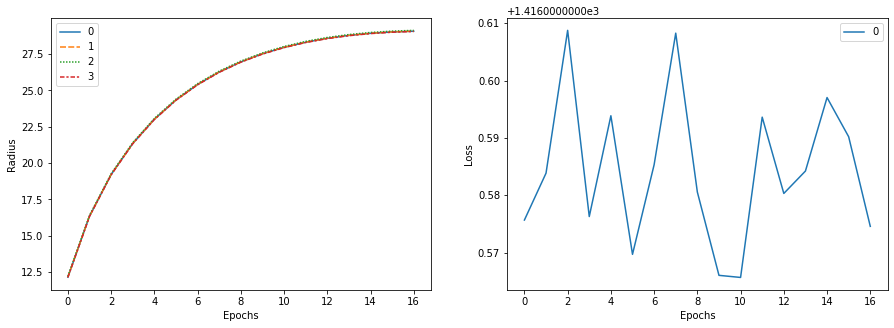

[[98  0  0  0  0]
 [ 0 92  0  0  0]
 [ 0  0 97  0  0]
 [ 0  0  0  2  0]
 [52  0 35  2  6]]
76.82
f1_weighted: 0.688142571454462, f1_macro: 0.6845925401104697, f1_micro: 0.7682291666666666, f_measure: {'Known': 82.6038, 'Open': 11.8812, 'F1-score': 68.4593}
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        98
           1       1.00      1.00      1.00        92
           2       0.73      1.00      0.85        97
           3       0.50      1.00      0.67         2
           5       1.00      0.06      0.12        95

    accuracy                           0.77       384
   macro avg       0.78      0.81      0.68       384
weighted avg       0.84      0.77      0.69       384



In [12]:
comment="700-950 , num_class=4, gave pretrained f1 23, so adding more data "
test_data, oset, hist = oset_train(ablation=1000,designated_ukc_cls=5,num_classes=4,embedding_size=2,
                             lr_rate=2, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

In [25]:
hist.history

{'loss': [1.095260739326477,
  0.9330243468284607,
  0.8765450119972229,
  0.8297002911567688,
  0.8145577907562256,
  0.7642148733139038,
  0.7557262182235718,
  0.7092770338058472,
  0.6836777329444885,
  0.6597353219985962,
  0.6235506534576416,
  0.6397823095321655,
  0.5323417782783508,
  0.2983563542366028],
 'accuracy': [0.46875,
  0.5206249952316284,
  0.573437511920929,
  0.6153125166893005,
  0.6387500166893005,
  0.6840624809265137,
  0.6762499809265137,
  0.7181249856948853,
  0.7265625,
  0.7318750023841858,
  0.770312488079071,
  0.7228124737739563,
  0.7953125238418579,
  0.9646875262260437],
 'precision_10': [0.7907268404960632,
  0.6881998181343079,
  0.692307710647583,
  0.7320312261581421,
  0.8145604133605957,
  0.8891075849533081,
  0.8861517906188965,
  0.9580374360084534,
  0.9685695767402649,
  0.9825693964958191,
  0.9744389057159424,
  0.980719804763794,
  0.9732739329338074,
  0.98838210105896],
 'recall_10': [0.19718749821186066,
  0.24968749284744263,
  0.2

In [31]:
%%time
pre_tr_acc = hist.history.get('accuracy')[len(hist.history.get('accuracy'))-1]
print(round(pre_tr_acc, 4))
pre_val_acc = hist.history.get('val_accuracy')[len(hist.history.get('val_accuracy'))-1]
print(round(pre_val_acc, 4))

0.9647
0.9661
CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
# import ipynbname
# nb_name = ipynbname.name()

In [1]:
import ipyparams
currentNotebook = ipyparams.notebook_name
print(currentNotebook)

<IPython.core.display.Javascript object>

In [40]:
dir(ipyparams)

['Javascript',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_ipython_support',
 'basename',
 'defaultdict',
 'display',
 'get_ipython',
 'notebook_name',
 'params',
 'parse_qs',
 'raw_params',
 'raw_url',
 'sleep',
 'target_func',
 'update_params',
 'urlparse']